In [2]:
from kd_ub import kd_traj
import numpy as np
import matplotlib.pyplot as plt

# Momentum Initialization

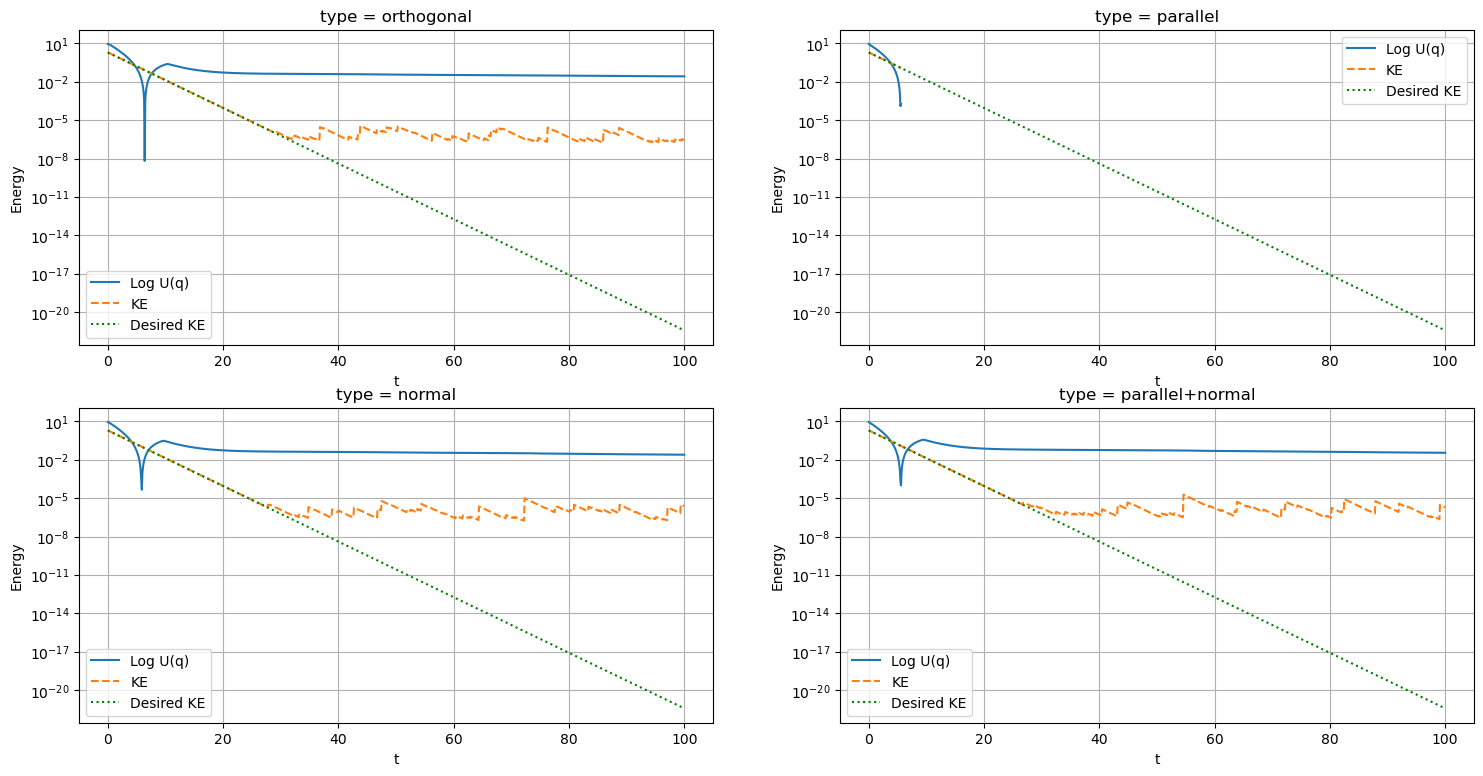

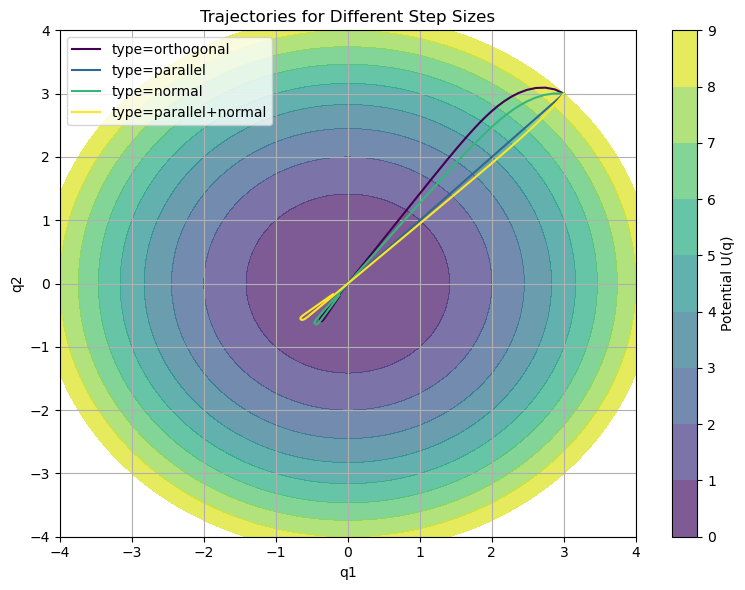

In [19]:
# Define parameters
Pars = {}
decay_exp = {
        'c': lambda t, P: np.exp(-P['gamma'] * t),
        'cp': lambda t, P: -P['gamma'] * np.exp(-P['gamma'] * t),
        'csqrt': lambda t, P: np.sqrt(np.exp(-P['gamma'] * t))
    }
Pars['decay'] = decay_exp
Model = {}

U_quad = lambda x, _: 0.5 * (x[0]**2 + x[1]**2)
F_quad = lambda x, _: -np.array([x[0], x[1]])

Model['U'] = U_quad
Model['F'] = F_quad

# Step sizes to test
gamma = .5
Pars['gamma'] = gamma
types = ['orthogonal', 'parallel', 'normal', 'parallel+normal']
T_final = 100  # Keep total simulation time fixed
trajectories = {}
h = 0.1
Ns = int(T_final / h)

# Compute trajectories for each step size
for type in types:
    x0 = np.array([3., 3.])
    if type == "orthogonal":
        vec = np.random.randn(2)
        vec = vec / np.linalg.norm(vec)
        grad = F_quad(x0, Pars)
        grad = grad / np.linalg.norm(grad)
        p0 = vec - (np.inner(grad, vec)/np.inner(grad, grad) * grad)
    elif type == "parallel":
        p0 = F_quad(x0, Pars)
    elif type == "normal":
        p0 = np.random.randn(2)
    elif type == "parallel+normal":
        p0 = F_quad(x0, Pars) + np.random.randn(2)
    p0 /= np.linalg.norm(p0)
    p0 *= np.sqrt(2)

    T, X, P, KE, PE = kd_traj(x0, p0, h, Ns, Pars, Model)
    trajectories[type] = (T, X, P, KE, PE)

# Plot all trajectories on a single contour plot
fig, axs = plt.subplots(2, 2, figsize=(18, 9))

x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X_grid, Y_grid = np.meshgrid(x, y)
Z = 0.5 * (X_grid**2 + Y_grid**2)

fig_contour, ax_contour = plt.subplots(figsize=(8, 6))
contourf = ax_contour.contourf(X_grid, Y_grid, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
fig.colorbar(contourf, ax=ax_contour, label='Potential U(q)')

# Plot each trajectory
colors = plt.cm.viridis(np.linspace(0, 1, len(types)))
for i, type in enumerate(types):
    _, X, _, _, _ = trajectories[type]
    ax_contour.plot(X[:, 0], X[:, 1], label=f'type={type}', color=colors[i], lw=1.5)

ax_contour.set_xlabel('q1')
ax_contour.set_ylabel('q2')
ax_contour.set_title('Trajectories for Different Step Sizes')
ax_contour.legend()
ax_contour.grid(True)

# Plot log potential and kinetic energy in a 2x4 grid
for i, type in enumerate(types):
    T, _, _, KE, PE = trajectories[type]

    row, col = divmod(i, 2)

    # Log potential energy plot
    axs[row, col].semilogy(T, PE, label='Log U(q)')
    axs[row, col].semilogy(T, KE, label='KE', linestyle='dashed')
    axs[row, col].semilogy(T, 2 * np.exp(-Pars['gamma'] * T), label='Desired KE', color='green', linestyle='dotted')

    axs[row, col].set_title(f'type = {type}')
    axs[row, col].set_xlabel('t')
    axs[row, col].set_ylabel('Energy')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()